# Analysis of flu data set of 2000 - 2016

With this project my goal was to explore the dataset avaialble at the WHO website (http://www.who.int/influenza/gisrs_laboratory/flunet/en/) and to see the seasonal variation of the flu, to explore the spatial distribution during the flu outbreaks. Furthermore I was interested in the seasonal variation of the different types and subtypes. In this project I also excercise my Python programiing skills, I use a bunch of different modules, such as NumPy, Pandas, Basemap, Shapefile, Matplotlib.

## Data and library imports

First, I import the data that I downloaded in chunks from the Flunet archives.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

files = ['2000-01-2016-52-pt1.csv',
         '2000-01-2016-52-pt2.csv',
         '2000-01-2016-52-pt3.csv',
         '2000-01-2016-52-pt4.csv',
         '2000-01-2016-52-pt5.csv']

raw_data = []

for file in files:
    tmp = pd.read_csv(file, skiprows=3)
    print tmp.shape
    raw_data.append(tmp)

data = pd.concat(raw_data, axis=0)

(3932, 22)
(6070, 22)
(3577, 22)
(1885, 22)
(5706, 22)


 The data looks pretty clean. Although, there are a lot of NaNs in the combined sheet, it does not defeat the data analysis.

In [2]:
data.head()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,Austria,European Region of WHO,South West Europe,2000,1,2000-01-03,2000-01-09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Widespread Outbreak
1,Austria,European Region of WHO,South West Europe,2000,2,2000-01-10,2000-01-16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Widespread Outbreak
2,Austria,European Region of WHO,South West Europe,2000,3,2000-01-17,2000-01-23,NaN,NaN,NaN,...,NaN,41.0,67.0,NaN,NaN,NaN,NaN,67.0,NaN,Widespread Outbreak
3,Austria,European Region of WHO,South West Europe,2000,4,2000-01-24,2000-01-30,NaN,NaN,NaN,...,NaN,2.0,10.0,NaN,NaN,NaN,0.0,10.0,NaN,Widespread Outbreak
4,Austria,European Region of WHO,South West Europe,2000,5,2000-01-31,2000-02-06,NaN,14.0,NaN,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,Regional Outbreak


The time can be inferred from the **Year** and **Week** coulmns, but also **SDATE** and **EDATE** may be used. The latter two is converted into time *datetime* type so that more advanced functions can be used on them.

In [3]:
# Updating dates
data['SDATE'] = pd.to_datetime(data['SDATE'], format='%Y-%m-%d')
data['EDATE'] = pd.to_datetime(data['EDATE'], format='%Y-%m-%d')

data['SDATE'][0]

0   2000-01-03
0   2010-10-04
0   2008-03-10
0   2000-01-03
0   2000-01-03
Name: SDATE, dtype: datetime64[ns]

## Cleaning up the country names a little bit

Country names require some work, because the way they are stored in the FluNet database does not agree with the way our map database has them. Also, some names are just plain too complicated, see Kosovo.

In [4]:
data['Country'].unique()

array(['Austria', 'Croatia', 'Hungary', 'Romania', 'Serbia', 'Slovakia',
       'Slovenia', 'Ukraine', 'Armenia', 'Belarus', 'Bulgaria', 'Estonia',
       'Finland', 'Georgia', 'Iceland', 'Ireland', 'Latvia', 'Lithuania',
       'Luxembourg', 'Republic of Moldova',
       'United Kingdom of Great Britain and Northern Ireland',
       'Azerbaijan', 'Bosnia and Herzegovina', 'Greece', 'Kazakhstan',
       'Kosovo (in accordance with Security Council resolution 1244 (1999))',
       'Malta', 'Montenegro', 'Norway', 'Russian Federation',
       'The former Yugoslav Republic of Macedonia', 'Turkey', 'Albania',
       'Italy', 'Sweden', 'Switzerland', 'Belgium', 'Czechia', 'Denmark',
       'France', 'Germany', 'Netherlands', 'Poland', 'Portugal', 'Spain'], dtype=object)

In [5]:
new_country_names = {'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                     'Kosovo (in accordance with Security Council resolution 1244 (1999))': 'Kosovo',
                     'Czechia': 'Czech Republic',
                     'Russian Federation': 'Russia'}

data['Country'] = data['Country'].apply(lambda x: new_country_names.get(x, x))

## Variation of the Flu-positive cases per country between flu seasons

It is well-known that in the northern hemisphere the flu season typically starts late November and lasts until late March. I was wondering how much variation is in this. I was interested in the flu seasons not the annual variation. Therefore, I offset the weeks, in a way that the beginning and the peak of the flu season would join. This generates a single peak.

In [6]:
def plt_multi_year(country='Hungary',
                   sel_column='ALL_INF',
                   years=[2016, 2015, 2014, 2013, 2012, 2011, 2010],
                   ax=None,
                   figsize=(4, 4),
                   offset=15):
    
    colors = ['red', 'blue', 'green', 'gray', 'black', 'orange', 'brown', 'cyan', 'pink'] # 9 colors at our disposal

    plot=False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        plot=True

    i=0
    for year in years:
        subset = data.loc[(data['Year']==year) &\
                          (data['Country']==country), :]
        if subset.shape[0] > 0:
            subset.loc[:, 'Week'] = (subset.loc[:, 'Week'] + offset) % 53
            ax = subset.plot('Week', sel_column, kind='scatter', color=colors[i], ax=ax)
            i += 1

    ax.set_xlim([0, 53])
    ax.set_ylim(bottom=0)
    ax.legend([str(x) for x in years])
    ax.set_title(country)
    ax.set_xlabel('Week + ' + str(offset))
    
    if offset > 0:
        ax.plot((offset, offset), (0, ax.get_ylim()[1]), 'r-')
    
    if plot:
        plt.show()
    else:
        return(ax)
    
#plt_multi_year(country='United Kingdom')

I generate the plot for each country so that the volume and the seasonal variation can be compared in the timeframe 2010-2016

c:\program files (x86)\python\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\program files (x86)\python\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


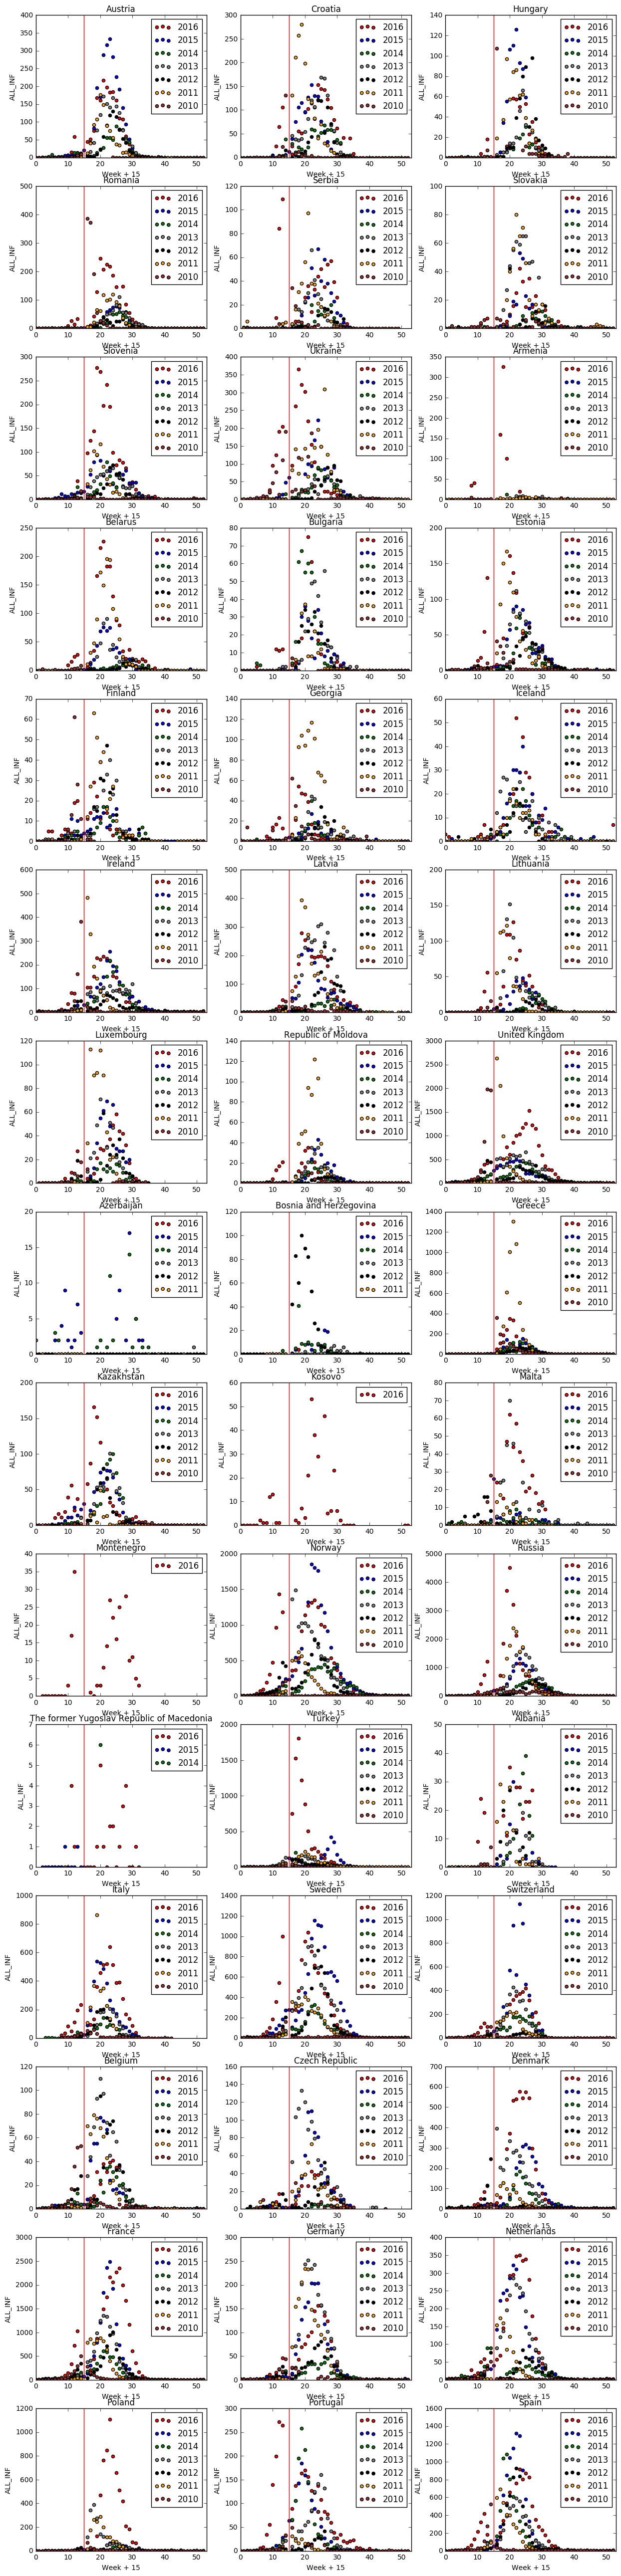

In [7]:
countries = data['Country'].unique()
fig = plt.figure(figsize=(15, 70))

for i in range(0, len(countries)):
    country = countries[i]
    plt_multi_year(country=country, ax=fig.add_subplot(16, 3, i+1))
    
fig.show()

## Overall variation of flu levels

Here I plot the cummulative case numbers per week per year to see the variation. With these plots I am trying to see if there can be a week number defined that separates two consecutive fluseasons.

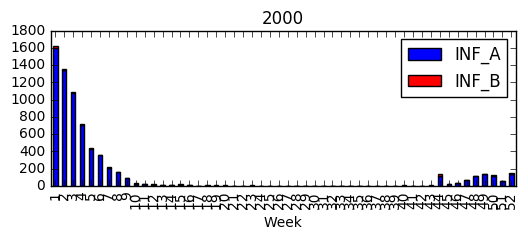

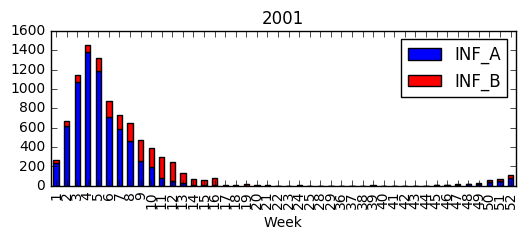

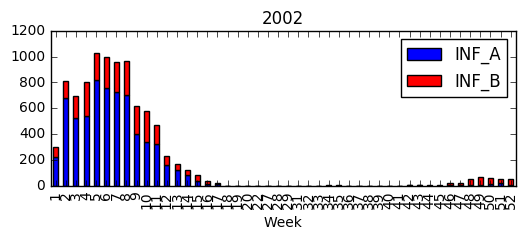

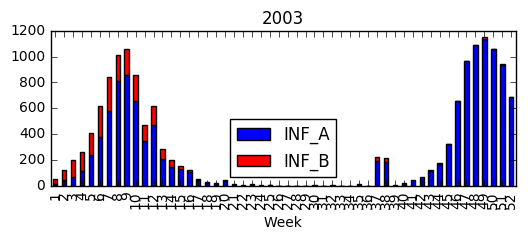

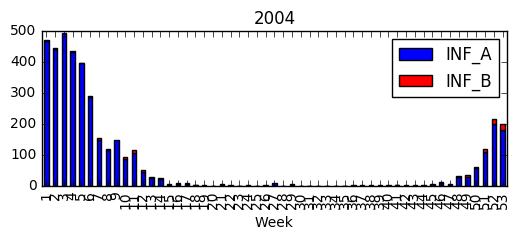

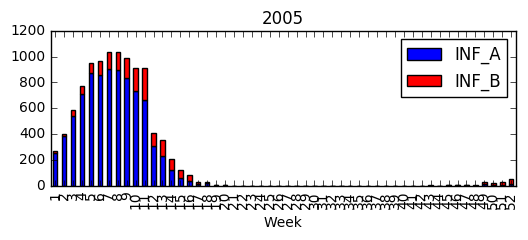

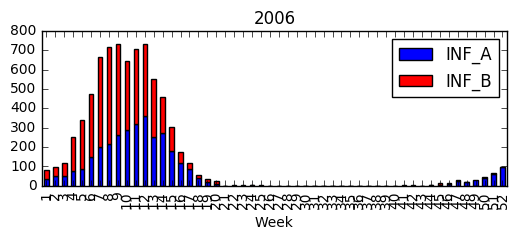

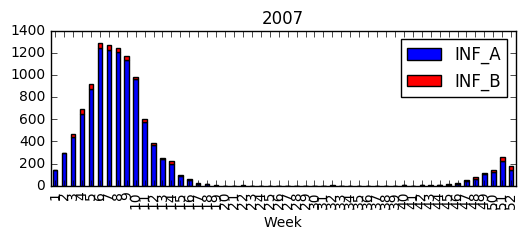

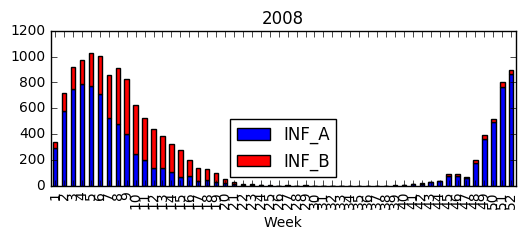

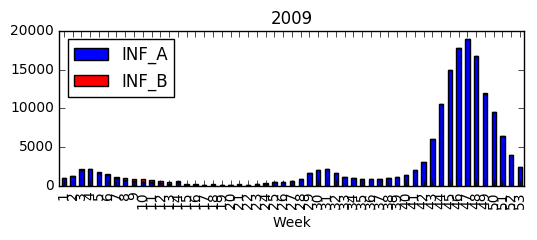

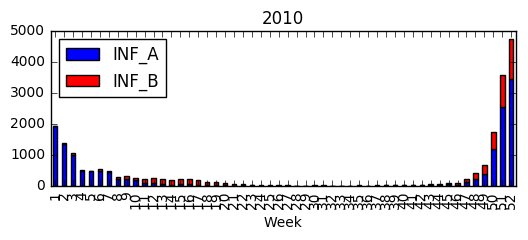

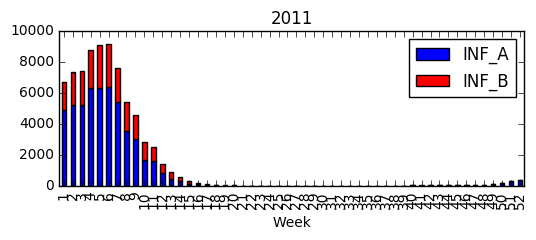

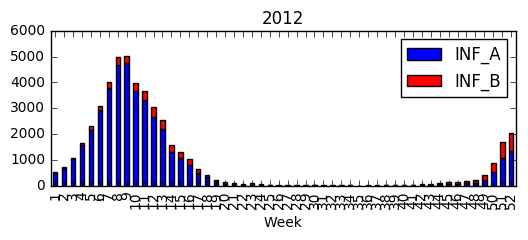

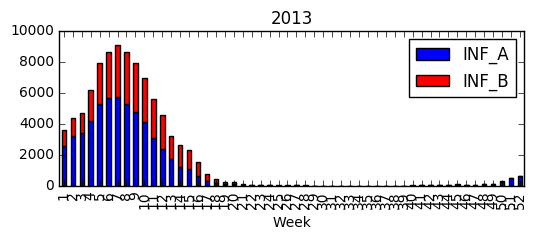

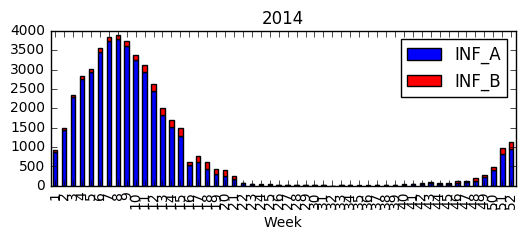

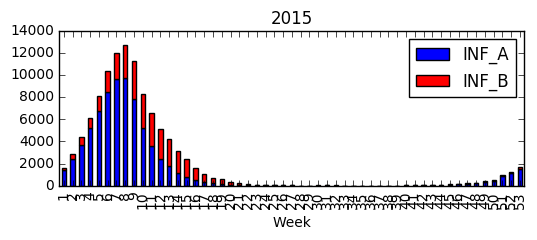

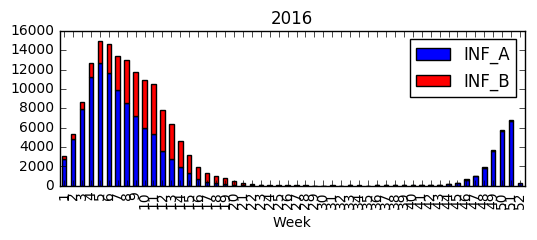

In [8]:
for year in sorted(data['Year'].unique()):
    data_agg = data.loc[data['Year']==year, :].groupby('Week').aggregate(np.sum)
    ax = data_agg.plot(y=['INF_A', 'INF_B'], kind='bar', color=['blue', 'red'], stacked=True, figsize=(6, 2))
    ax.set_title(year)
    plt.show()

Week number **28** seems to be an OK compromise, it will be suboptimal for 2009, but will work for all the rest.

### Defining Flu seasons

Any week number smaller or equal to 28 belongs to the previous flu season, and anything above to the next.

In [9]:
def season_helper(x):
    year = x['Year']
    if x['Week'] <28:
        return '{}/{}'.format(year-1, year)
    else:
        return '{}/{}'.format(year, year+1)
data['Season'] = data.apply(season_helper, axis=1)
# data.head()

## Flu samples received and processed per year and per season

I wanted to see how much more aware we are of the flu.

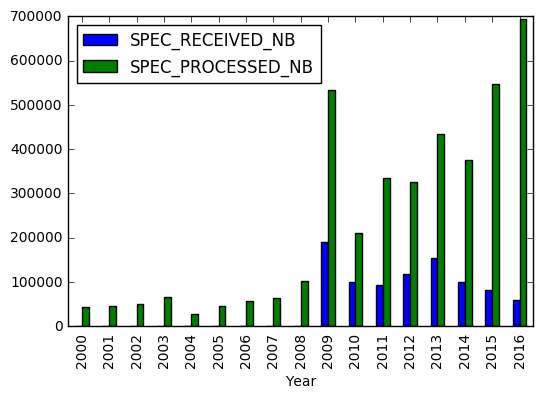

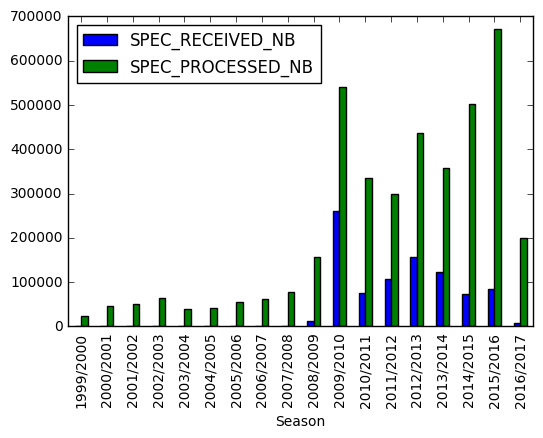

In [10]:
data_agg_year = data.groupby('Year').aggregate(np.sum)
data_agg_year.plot(y=['SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB'], color=['blue', 'green'], kind='bar')
plt.show()
data_agg_season = data.groupby('Season').aggregate(np.sum)
data_agg_season.plot(y=['SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB'], color=['blue', 'green'], kind='bar')
plt.show()

# Influenza type variation per year and per flu season

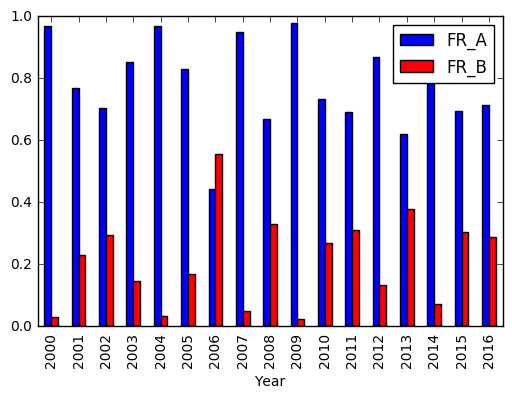

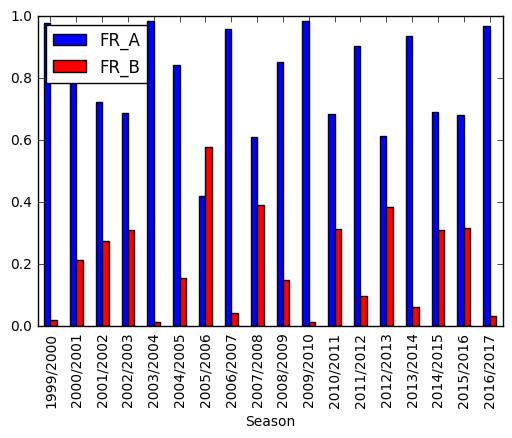

In [11]:
data_agg_year['FR_A'] = data_agg_year['INF_A'] / data_agg_year['ALL_INF']
data_agg_year['FR_B'] = 1 - data_agg_year['FR_A']
ax = data_agg_year.plot(y=['FR_A', 'FR_B'], kind='bar', color=['blue', 'red'])
plt.show()
data_agg_season['FR_A'] = data_agg_season['INF_A'] / data_agg_season['ALL_INF']
data_agg_season['FR_B'] = 1 - data_agg_season['FR_A']
ax = data_agg_season.plot(y=['FR_A', 'FR_B'], kind='bar', color=['blue', 'red'])
plt.show()

The two plots tell the same story: the most common disease causing type is the A (which can cross the species boundry), however the B type (Human only) virus was responsible for the majoritiy of the disease cases in the 2005/2006 flu season.

## Influenza Subtypes

It maybe interesting to see how the different subtypes (Particularly the A H1, H3) contribute. Since there were not H5 types in the samples I will discard this column from my investigation.

In [12]:
subtypes_a = list(data_agg_year.columns[3:8])
del subtypes_a[3]
subtypes_b = data_agg_year.columns[9:12]

### a) based on data aggregated by year

I calculate the fraction of each subtype in the main type (*e.g.* H1 in all INF_A)

In [13]:
for subtype in subtypes_a:
    data_agg_year['FR_' + subtype] = data_agg_year[subtype] / data_agg_year['INF_A']
    
for subtype in subtypes_b:
    data_agg_year['FR_' + subtype] = data_agg_year[subtype] / data_agg_year['INF_B']

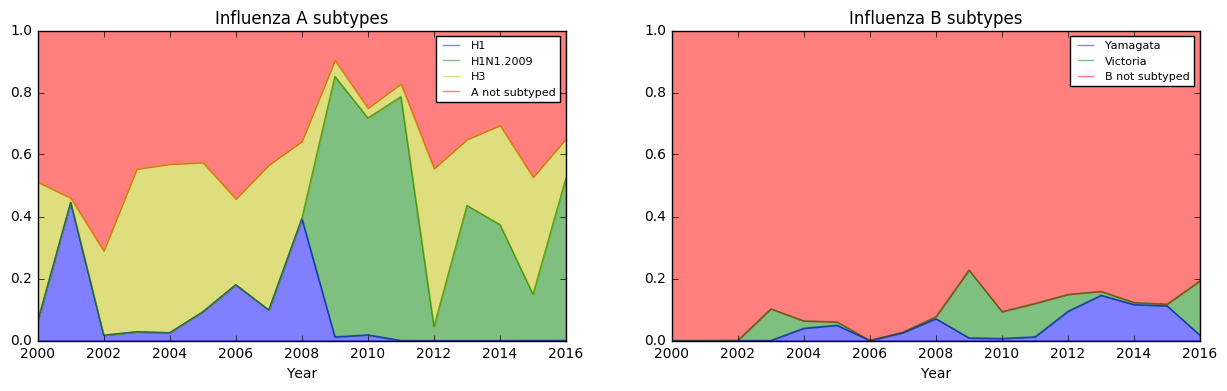

In [14]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,2,1)
data_agg_year.plot(y=['FR_' + x for x in subtypes_a], kind='area', 
                   legend=None, alpha=0.5, ax=ax,
                   color=['b', 'g', 'y', 'r'])
ax.legend(['H1', 'H1N1.2009', 'H3', 'A not subtyped'], fontsize=8)
ax.set_ylim(top=1)
ax.set_title('Influenza A subtypes')
ax = fig.add_subplot(1,2,2)
data_agg_year.plot(y=['FR_' + x for x in subtypes_b], kind='area', legend=None, alpha=0.5, ax=ax)
ax.legend(['Yamagata', 'Victoria', 'B not subtyped'], fontsize=8)
ax.set_ylim(top=1)
ax.set_title('Influenza B subtypes')
plt.show()

### b) based on flu seasons

Similarly to above, I perform the analyisis per flu-season to get a more accurate picture.

In [15]:
for subtype in subtypes_a:
    data_agg_season['FR_' + subtype] = data_agg_season[subtype] / data_agg_season['INF_A']
    
for subtype in subtypes_b:
    data_agg_season['FR_' + subtype] = data_agg_season[subtype] / data_agg_season['INF_B']

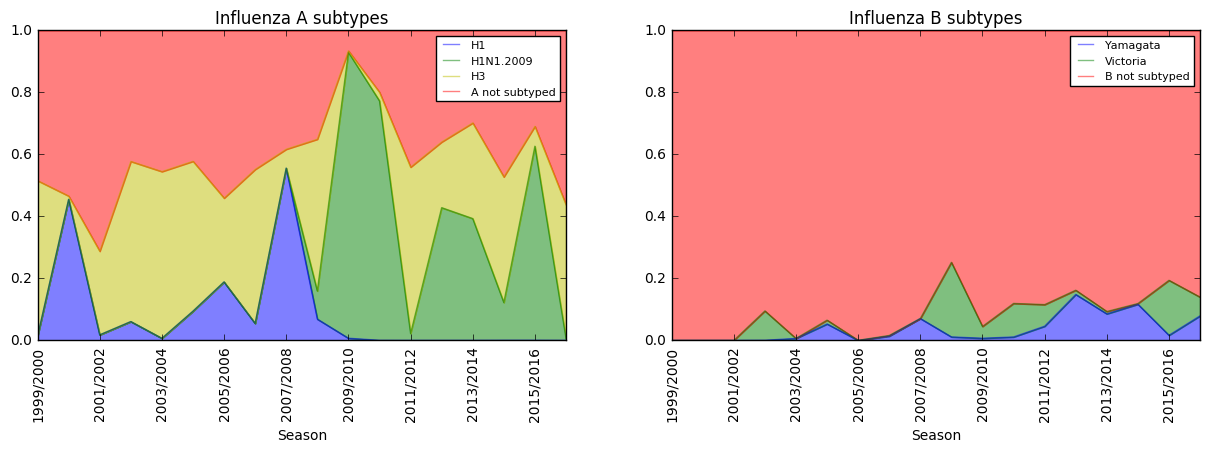

In [16]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,2,1)
data_agg_season.plot(y=['FR_' + x for x in subtypes_a], kind='area', 
                     legend=None, alpha=0.5, ax=ax,
                     color=['b', 'g', 'y', 'r'])
ax.legend(['H1', 'H1N1.2009', 'H3', 'A not subtyped'], fontsize=8)
ax.set_ylim(top=1)
ax.set_title('Influenza A subtypes')
plt.xticks(rotation=90)
ax = fig.add_subplot(1,2,2)
data_agg_season.plot(y=['FR_' + x for x in subtypes_b], kind='area', legend=None, alpha=0.5, ax=ax)
ax.legend(['Yamagata', 'Victoria', 'B not subtyped'], fontsize=8)
ax.set_ylim(top=1)
ax.set_title('Influenza B subtypes')
plt.xticks(rotation=90)
plt.show()

While not all the A types are checked for the subtype it is clear that H1 and H3 are the most common A subtypes. In 2009 the overwhelming majority of the diseases were caused by the H1N1 subtype and it appears that from that onwards all H1 subtypes are identical to it. (It also may mean that the test of H1 subtype is no longer available). The screening volume was the highest in the 2009/2010 season. High proportion of H3 was seen in 2003/2004, 2011/2012 flu seasons.

The B type rarely gets subtyped, only about 20% of the samples. There is an alteration between the prevalence of the Yamagata and Victoria strains, but the data is insufficient to say more.

# Mapping the data onto the map of Europe

I was interested how the disease spreads from country to country in Europe. I used a database from http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip and with the help of the Basemap package and a tutorial by Thomas Lecocq (http://www.geophysique.be/2013/02/12/matplotlib-basemap-tutorial-10-shapefiles-unleached-continued/) I managed to put together a user-friendly class that does the mapping.

In [17]:
class Map:
    countries = None
    colors = []
    na_color = (0.5, 0.5, 0.5)
    
    map_colors = {'lake_color': 'dodgerblue', 
                  'continents': 'coral', 
                  'map_boundary': 'dodgerblue'}
    
    corners = {'ll_lon' : -25,
               'll_lat' : 30,
               'ur_lon' : 65,
               'ur_lat' : 72}
    
    projection = 'merc'
    
    resolution = 'l'
    
    records_f = []
    shapes_f = []
    
    
    def __init__(self, shape_file, countries=None):
        import shapefile
        shp_res = shapefile.Reader(shape_file)
        self.shapes = shp_res.shapes()
        self.records = shp_res.records()
        self.countries = countries
        self.shape_selector()
            
            
    def shape_selector(self):
        self.records_f = []
        self.shapes_f = []
        self.db_countries = []
        if self.countries is not None:
            for record, shape in zip(self.records, self.shapes):
                self.db_countries.append(record[4])
                if record[4] in countries:
                    self.records_f.append(record)
                    self.shapes_f.append(shape)
                    
            missed_countries = []
            for country in self.countries:
                if country not in self.db_countries:
                    missed_countries.append(country)
                    
            if len(missed_countries) > 0:
                print('The following countries did not match database names:')
                print(missed_countries)
                print('Check your list against self.db_countries!')
        
    def plot(self, ax=None):
        from mpl_toolkits.basemap import Basemap
        from matplotlib.patches import Polygon
        from matplotlib.collections import LineCollection

        if ax is None:
            ax = plt.subplot(111)
            

        m = Basemap(projection=self.projection,
                    llcrnrlat=self.corners['ll_lat'],
                    llcrnrlon=self.corners['ll_lon'],
                    urcrnrlat=self.corners['ur_lat'],
                    urcrnrlon=self.corners['ur_lon'],
                    lon_0=0,
                    resolution=self.resolution,
                    ax=ax)
        
        # draw coastlines, country boundaries, fill continents.
        m.drawmapboundary(fill_color=self.map_colors['map_boundary'])
        m.drawcoastlines(linewidth=1)
        m.fillcontinents(color=self.map_colors['continents'], 
                         lake_color=self.map_colors['lake_color'])

        color_dict = dict(zip(self.countries, self.colors))
        
        for record, shape in zip(self.records_f, self.shapes_f):
            lons, lats = zip(*shape.points)
            map_data = np.array(m(lons, lats)).T

            if len(shape.parts) == 1:
                segs = [map_data, ]
            else:
                segs = []
                for i in range(1, len(shape.parts)):
                    index = shape.parts[i-1]
                    index2 = shape.parts[i]
                    segs.append(map_data[index:index2])
                segs.append(map_data[index2:])

            lines = LineCollection(segs, antialiaseds=(1, ))
            lines.set_facecolors(color_dict.get(record[4], self.na_color))
            lines.set_edgecolors('k')
            lines.set_linewidth(0.75)
            ax.add_collection(lines)
        
        return ax
        
mapper = Map('map_data/TM_WORLD_BORDERS-0.3.shp', list(data['Country'].unique()))

The following countries did not match database names:
['Kosovo']
Check your list against self.db_countries!


## Testing the mapping function with a selected week

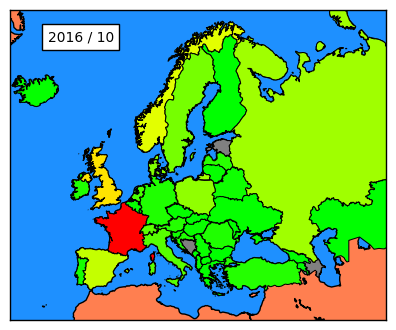

In [18]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
my_cm = LinearSegmentedColormap.from_list('green_yellow_red', [(1, 0, 0), (1, 1, 0) ,(0, 1, 0)], N=100)

year = 2016
week = 10
inf_totals = data.loc[(data['Year'] == year) &\
                      (data['Week'] == week), ['Country', 'ALL_INF']]

inf_total_max = int(inf_totals.max()[1])

mapper.countries = inf_totals['Country']
mapper.colors = [my_cm(x) for x in (1-inf_totals['ALL_INF']/inf_total_max).tolist()]
ax = mapper.plot()
ax.text(0.1, 0.9, '{} / {}'.format(year, week), 
        transform=ax.transAxes,
        bbox=dict(facecolor='white'))
plt.show()

Here red means the absolute maximum of cases in the Week, green is close to 0 or the minimum.

## Better maps to illustrate the disease spread

As we have seen above the outbreaks in each flu season follow a bell-shaped curve. The maximum is different for each country and the peak varies from season to season. Therefore, the actual value must be normalized to the peak of the current season in order to better illustrate the diesease spread. Then, the values can be ploted to the map and color coded. This way the colors will represent the actual value relative to the seasons peak.

In [19]:
seasonal_max = data.fillna(0).groupby(['Country', 'Season'], group_keys=False).aggregate(np.max)
data['ALL_INF_REL_SEASON'] = data.apply(lambda x: float(x['ALL_INF'])/int(1+seasonal_max['ALL_INF'][x['Country']][x['Season']]),
                                        axis=1)

Enable the code below to produce the figure in the next cell.

c:\program files (x86)\python\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


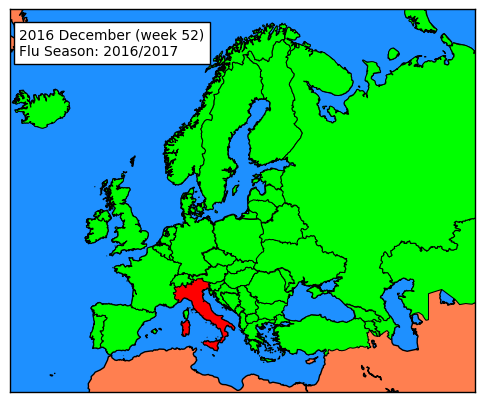

In [21]:
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(111)
# for year in [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]:
#     # year = 2016
#     for week in range(1, data.loc[data['Year'] == year, 'Week'].max() + 1):
#     #     week = 13

#         subset = data.loc[(data['Year'] == year) &\
#                           (data['Week'] == week), :]

#         mapper.countries = subset['Country']
#         mapper.colors = [my_cm(x) for x in (1-subset['ALL_INF_REL_SEASON']).tolist()]
#         mapper.na_color = (0, 1, 0)
#         ax.cla()
#         ax = mapper.plot()
#         ax.text(0.02, 0.88, subset['SDATE'].iloc[0].strftime('%Y %B (week %W)\nFlu Season: {}').format(subset['Season'].iloc[0]), 
#                 transform=ax.transAxes,
#                 bbox=dict(facecolor='white'))
#         plt.savefig('figures2/map_{}_{:02d}.png'.format(year, week, ), dpi=100)

![Figure 1](./figures/animated.gif "Figure")